In [1]:
import sys
import os
import boto3
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from xarray import open_mfdataset
from cloudflow.services.S3Storage import S3Storage


In [2]:
def make_indexhtml(indexfile : str, imagelist : list):

    htmlhead = '''<html xmlns="http://www.w3.org/1999/xhtml">
                  <head>
                  <title>Cloud-Sandbot</title>'''

    htmlbody = '<body>\n'
    for image in imagelist:
       imagehtml = f'<img src="{image}">\n'
       htmlbody += imagehtml

    htmlbody += '</body>\n'
    html = f'''{htmlhead}
               {htmlbody}
               </html>'''

    with open(indexfile, 'w') as index:
        index.write(html) 
        

In [3]:
def roms_nosofs(COMDIR: str, OFS: str, HH: str):
    '''Load ROMS NOSOFS dataset'''

    # Should not use single leterr variable names
    # Choose a name that describes what it is
    filespec = f'{COMDIR}/nos.{OFS}.fields.f*.t{HH}z.nc'
    print(f'filespec is: {filespec}')
    return open_mfdataset(filespec, decode_times=False, combine='by_coords')


In [4]:
def plot_rho(ds, variable, s3upload=False) -> str:
    
    if variable == 'zeta':
        da = ds[variable].isel(ocean_time=0)
        cmap = cmocean.cm.phase
    if variable == 'temp':
        da = ds[variable].isel(ocean_time=0, s_rho=0)
        cmap = cmocean.cm.thermal
    if variable == 'salt':
        da = ds[variable].isel(ocean_time=0, s_rho=0)
        cmap = cmocean.cm.haline
    if variable == 'oxygen':
        da = ds[variable].isel(ocean_time=0, s_rho=0)
        cmap = cmocean.cm.oxy
    if variable == 'Pair':
        da = ds[variable].isel(ocean_time=0)
        cmap = cmocean.cm.diff
      
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_axes([0,0,1,1], projection=ccrs.PlateCarree())
    im = ax.contourf(da.lon_rho, da.lat_rho, da.values,
                     transform=ccrs.PlateCarree(), 
                     cmap=cmap)
    
    coast_10m = cfeature.NaturalEarthFeature(
        'physical', 'land', '10m',
        edgecolor='k', facecolor='0.8'
    )
    ax.add_feature(coast_10m);
    
    title = ds.attrs['title']
    history = ds.history
    now = datetime.now().strftime("%m/%d/%Y, %H:%M:%S")
    ax.set_title(f"Image generated on {now}\n\n{title}\n{history}");
    
    cbar = fig.colorbar(im, ax=ax)
    long_name = da.attrs['long_name']
    if variable != 'salt':
        units = da.attrs['units']
        cbar.set_label(f'{long_name} ({units})')
    else:
        cbar.set_label(f'{long_name}')
    
    indexfile = f'docs/index.html'
    outfile = f'docs/{variable}.png'
    
    if not os.path.exists('./docs'):
        os.makedirs('./docs')

    imagename = outfile.split('/')[-1]

    plt.savefig(outfile, bbox_inches='tight')
                 
    if s3upload:
        s3 = S3Storage()
        bucket = 'ioos-cloud-www'
        s3.uploadFile(outfile, bucket, f'{variable}.png', public = True)

    return imagename


In [5]:
def main(argv):

    COMDIR = argv[1]
    OFS = argv[2]
    HH = argv[3]

    print(f'COMDIR is: {COMDIR}')
    print(f'OFS is: {OFS}')
    print(f'HH is: {HH}')
    print('Running ...')


    # could check that this is a roms model
    # if ofs in utils.roms_models then do roms
    # else if ofs in utils.fvcom_models then do fvcom

    ds_roms = roms_nosofs(COMDIR, OFS, HH)
    indexfile = f'docs/index.html'
    if not os.path.exists('./docs'):
        os.makedirs('./docs')

    bucket = 'ioos-cloud-www'

    storageService = S3Storage()

    rho_vars = ['temp',"zeta", "salt" ]

    imagelist = []

    for var in rho_vars:
        imagename = plot_rho(ds_roms, var, s3upload=True)
        imagelist.append(imagename)

    make_indexhtml(indexfile, imagelist)
    storageService.uploadFile(indexfile, bucket, 'index.html', public=True, text=True)
    
    print('Finished ...')
    return ds_roms

    

In [6]:
COMDIR='/com/nos/cbofs.2020081800'
OFS='cbofs'
HH='00'

COMDIR is: /com/nos/cbofs.2020081800
OFS is: cbofs
HH is: 00
Running ...
filespec is: /com/nos/cbofs.2020081800/nos.cbofs.fields.f*.t00z.nc
Finished ...


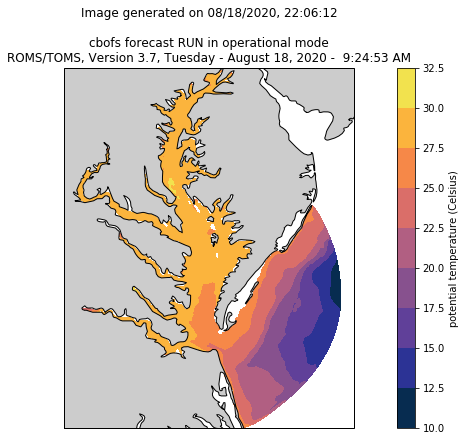

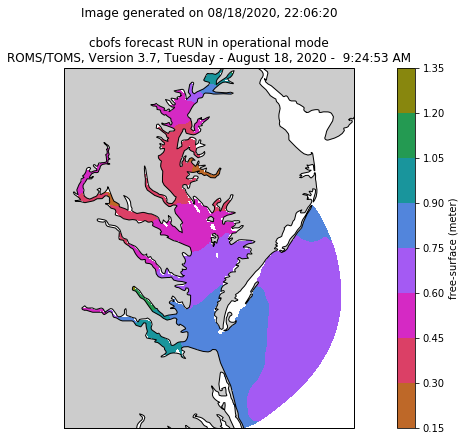

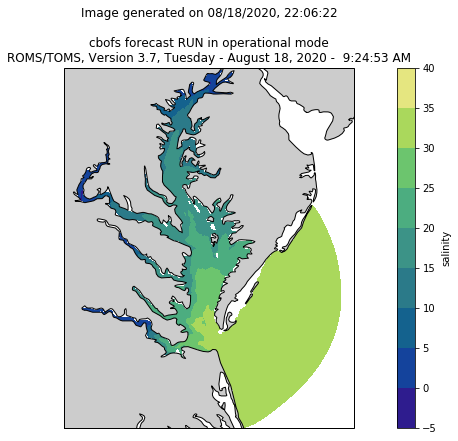

In [7]:
dsroms = main(['none',COMDIR,OFS,HH])

In [15]:
from cloudflow.workflows import flows

flows.inject_notebook()

[2020-08-18 15:24:34,608] INFO - flow_runner.run | Beginning Flow run for 'notebook test'
[2020-08-18 15:24:34,614] INFO - flow_runner.set_flow_to_running | Starting flow run.
[2020-08-18 15:24:34,641] INFO - task_runner.run | Task 'run_pynotebook': Starting task run...


 2020-08-18 15:24:34,642  INFO - tasks.run_pynotebook | Running sandbot_test.py


COMDIR is: /com/nos/cbofs.2020081800
OFS is: cbofs
HH is: 00
filespec is: /com/nos/cbofs.2020081800/nos.cbofs.fields.f*.t00z.nc

[2020-08-18 15:25:02,596] INFO - task_runner.run | Task 'run_pynotebook': finished task run for task with final state: 'Success'
[2020-08-18 15:25:02,598] INFO - flow_runner.determine_final_state | Flow run SUCCESS: all reference tasks succeeded
PASSED


In [8]:
dsroms

<xarray.Dataset>
Dimensions:         (boundary: 4, eta_psi: 290, eta_rho: 291, eta_u: 291, eta_v: 290, ocean_time: 48, s_rho: 20, s_w: 21, tracer: 3, xi_psi: 331, xi_rho: 332, xi_u: 331, xi_v: 332)
Coordinates:
    lon_rho         (eta_rho, xi_rho) float64 dask.array<chunksize=(291, 332), meta=np.ndarray>
    lat_v           (eta_v, xi_v) float64 dask.array<chunksize=(290, 332), meta=np.ndarray>
    lon_u           (eta_u, xi_u) float64 dask.array<chunksize=(291, 331), meta=np.ndarray>
    lon_psi         (eta_psi, xi_psi) float64 dask.array<chunksize=(290, 331), meta=np.ndarray>
    lat_psi         (eta_psi, xi_psi) float64 dask.array<chunksize=(290, 331), meta=np.ndarray>
    lat_rho         (eta_rho, xi_rho) float64 dask.array<chunksize=(291, 332), meta=np.ndarray>
    lat_u           (eta_u, xi_u) float64 dask.array<chunksize=(291, 331), meta=np.ndarray>
    lon_v           (eta_v, xi_v) float64 dask.array<chunksize=(290, 332), meta=np.ndarray>
  * s_w             (s_w) float64 -1.0 -0.95 -0.9 -0.85 ... -0.15 -0.1 -0.05 0.0
  * s_rho           (s_rho) float64 -0.975 -0.925 -0.875 ... -0.075 -0.025
  * ocean_time      (ocean_time) float64 1.461e+08 1.461e+08 ... 1.463e+08
Dimensions without coordinates: boundary, eta_psi, eta_rho, eta_u, eta_v, tracer, xi_psi, xi_rho, xi_u, xi_v
Data variables:
    ntimes          (ocean_time) int32 34560 34560 34560 ... 34560 34560 34560
    ndtfast         (ocean_time) int32 20 20 20 20 20 20 ... 20 20 20 20 20 20
    dt              (ocean_time) float64 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0
    dtfast          (ocean_time) float64 0.25 0.25 0.25 0.25 ... 0.25 0.25 0.25
    dstart          (ocean_time) float64 1.691e+03 1.691e+03 ... 1.691e+03
    nHIS            (ocean_time) int32 720 720 720 720 720 ... 720 720 720 720
    ndefHIS         (ocean_time) int32 720 720 720 720 720 ... 720 720 720 720
    nRST            (ocean_time) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    nSTA            (ocean_time) int32 72 72 72 72 72 72 ... 72 72 72 72 72 72
    Falpha          (ocean_time) float64 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0
    Fbeta           (ocean_time) float64 4.0 4.0 4.0 4.0 4.0 ... 4.0 4.0 4.0 4.0
    Fgamma          (ocean_time) float64 0.284 0.284 0.284 ... 0.284 0.284 0.284
    nl_tnu2         (ocean_time, tracer) float64 dask.array<chunksize=(1, 3), meta=np.ndarray>
    nl_visc2        (ocean_time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    LuvSponge       (ocean_time) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    LtracerSponge   (ocean_time, tracer) int32 dask.array<chunksize=(1, 3), meta=np.ndarray>
    Akt_bak         (ocean_time, tracer) float64 dask.array<chunksize=(1, 3), meta=np.ndarray>
    Akv_bak         (ocean_time) float64 5e-05 5e-05 5e-05 ... 5e-05 5e-05 5e-05
    Akk_bak         (ocean_time) float64 5e-06 5e-06 5e-06 ... 5e-06 5e-06 5e-06
    Akp_bak         (ocean_time) float64 5e-06 5e-06 5e-06 ... 5e-06 5e-06 5e-06
    rdrg            (ocean_time) float64 0.0003 0.0003 0.0003 ... 0.0003 0.0003
    rdrg2           (ocean_time) float64 0.005 0.005 0.005 ... 0.005 0.005 0.005
    Zob             (ocean_time) float64 0.0005 0.0005 0.0005 ... 0.0005 0.0005
    Zos             (ocean_time) float64 0.02 0.02 0.02 0.02 ... 0.02 0.02 0.02
    gls_p           (ocean_time) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
    gls_m           (ocean_time) float64 0.5 0.5 0.5 0.5 0.5 ... 0.5 0.5 0.5 0.5
    gls_n           (ocean_time) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
    gls_cmu0        (ocean_time) float64 0.5477 0.5477 0.5477 ... 0.5477 0.5477
    gls_c1          (ocean_time) float64 0.555 0.555 0.555 ... 0.555 0.555 0.555
    gls_c2          (ocean_time) float64 0.833 0.833 0.833 ... 0.833 0.833 0.833
    gls_c3m         (ocean_time) float64 -0.6 -0.6 -0.6 -0.6 ... -0.6 -0.6 -0.6
    gls_c3p         (ocean_time) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    gls_sigk        (ocean_time) float64 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 